In [1]:
pip install -i https://test.pypi.org/simple/ VASA

In [ ]:
import os
import pandas as pd
import geopandas as gpd
from VASA import VASA

In [4]:
counties_map = gpd.read_file("../test data/counties.geojson") \
    .set_crs(epsg=4326) \
    .to_crs("+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs")

# filter out to only continental us
counties_map = counties_map[[(state != '02' and state != '15' and int(state) < 60) for state in counties_map.STATEFP]]

counties_map.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,06,075,00277302,0500000US06075,06075,San Francisco,06,121485107,479107241,"POLYGON ((-2168086.764 33798.997, -2176962.349..."
1,25,025,00606939,0500000US25025,25025,Suffolk,06,150855462,160479920,"POLYGON ((1901690.921 519844.627, 1902812.906 ..."
2,31,007,00835826,0500000US31007,31007,Banner,06,1932676697,397069,"POLYGON ((-629496.462 227201.747, -576250.975 ..."
3,37,181,01008591,0500000US37181,37181,Vance,06,653705784,42187365,"POLYGON ((1476930.940 -269973.669, 1488024.098..."
4,48,421,01383996,0500000US48421,48421,Sherman,06,2390651189,428754,"POLYGON ((-521740.024 -394881.325, -510740.158..."


In [5]:
# import the data file:
data = pd.read_csv("../test data/counties.csv")

# need to ensure that these GEOID's match the ones in our GeoDataFrame - add leading zeros
data.fips = [f"{d:05}" for d in data.fips]

data.head()

,fips,ds_m4,sg_avg_dist2
0,45035,2020-01-01,11066.255084
1,45035,2020-01-02,13048.934918
2,45035,2020-01-03,13383.727687
3,45035,2020-01-04,11845.334563
4,45035,2020-01-05,9796.491319


In [6]:
v = VASA(
    df=data,
    gdf=counties_map,
    group_summary=lambda g: g[:2], # state level
    df_group_col="fips",
    gdf_group_col="GEOID",
    date_col="ds_m4",
    temp_res="week",
    date_format="%Y-%m-%d"
).group()

In [7]:
v.pct_full_missing()

array([0.03217503])

In [8]:
v.fill_missing()

/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 1839, 2708.
  warnings.warn(message)


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

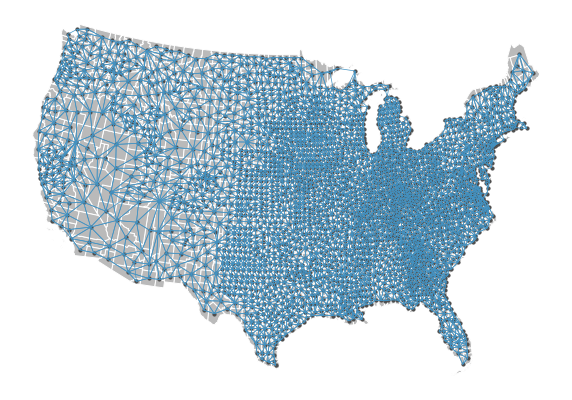

In [9]:
v.show_weights_connection(k=3, type="union")

In [ ]:
v.lisa(k=3, type="union")

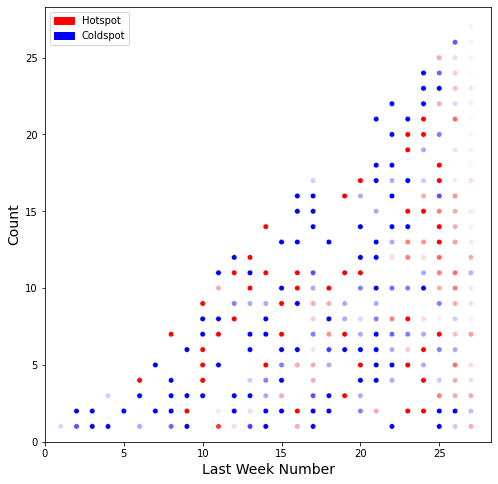

In [11]:
from VASA.scatter import Scatter
sc = Scatter(v)
sc.plot()

In [12]:
from VASA.static_choropleth import StackedChoropleth
stacked = StackedChoropleth(v, os.getcwd() + "/imgs/counties")

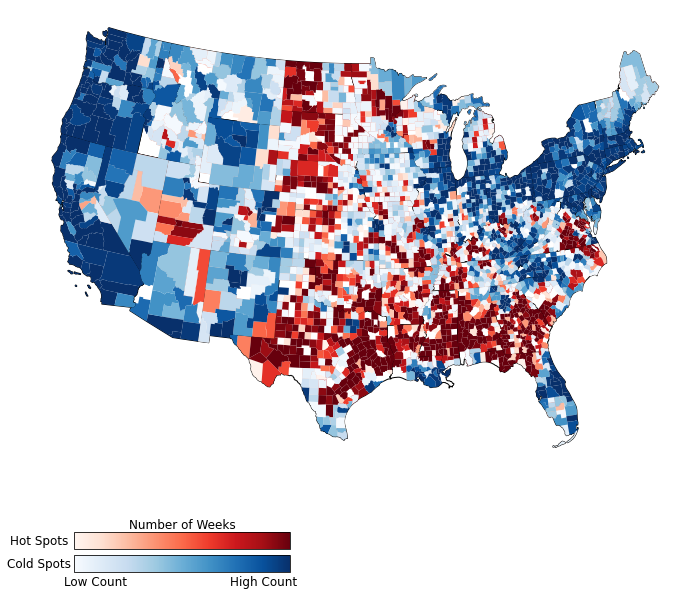

In [13]:
stacked.plot_count()

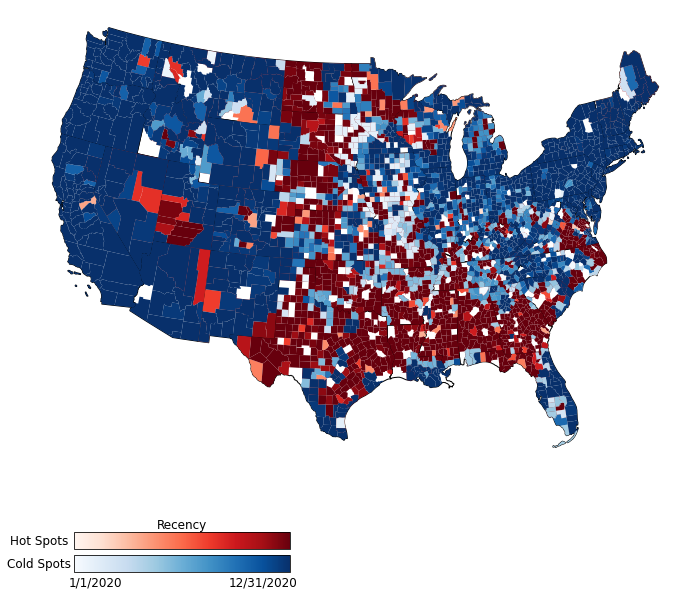

In [14]:
stacked.plot_recent()

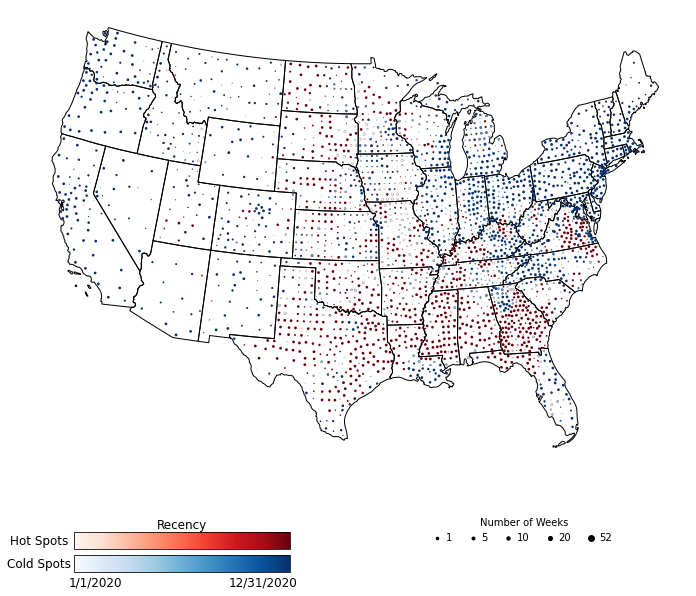

In [15]:
stacked.plot_both()